# 1. Loading Packages and libraries

In [4]:
import pandas as pd
import os
from os import environ
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import cv2
import tensorflow as tf
from tqdm import tqdm
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
import PIL.Image
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from IPython.display import display, Image
from tkinter import *
from PIL import ImageTk, Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow import keras

ImportError: cannot import name 'type_spec_registry' from 'tensorflow.python.framework' (/Users/yaramusad/anaconda3/envs/deepLearning/lib/python3.10/site-packages/tensorflow/python/framework/__init__.py)

# 2. Create datasets

## Load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Creating dataframe by iterating through filepaths
tumor_dir=r'/content/drive/MyDrive/DSCI 471-Project/archive/yes'
healthy_dir=r'/content/drive/MyDrive/DSCI 471-Project/archive/no'


filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list): 
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
1  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
2  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
3  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
4  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
cancer     155
healthy     98
Name: labels, dtype: int64


In [ ]:
tumor_df.shape

(253, 2)

In [ ]:
tumor_df.head()

,filepaths,labels
0,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
1,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
2,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
3,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
4,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer


## Split datasets

In [ ]:
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_images, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

In [ ]:
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(76, 2)
(36, 2)
(141, 2)


## Display data

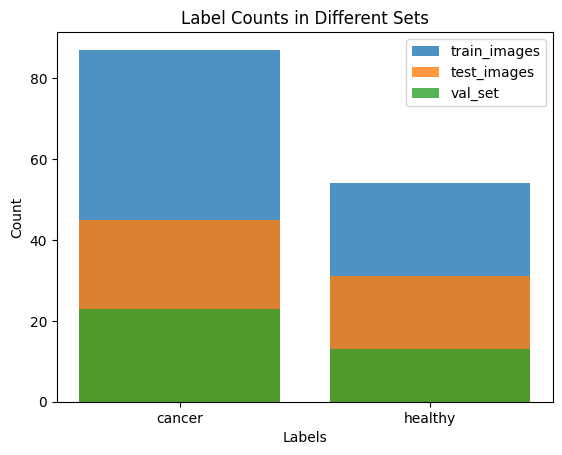

In [ ]:
# Count the occurrences of each label for each table
train_label_counts = train_images['labels'].value_counts()
test_label_counts = test_images['labels'].value_counts()
val_label_counts = val_set['labels'].value_counts()

# Plot the bar charts
plt.bar(train_label_counts.index, train_label_counts.values, alpha=0.8, label='train_images')
plt.bar(test_label_counts.index, test_label_counts.values, alpha=0.8, label='test_images')
plt.bar(val_label_counts.index, val_label_counts.values, alpha=0.8, label='val_set')

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Counts in Different Sets')

plt.legend()
plt.show()

### Data/Image Augmentation
Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness.

We will use data/image augmentation using ImageDataGenerator class to train the model on different types of combinations formed by rotation, flipping, changing the brightness etc of an image so as to increase our model accuracy.

Crop image

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
image_size = 224
batch_size = 32

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
train_images

,filepaths,labels
149,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
249,/content/drive/MyDrive/DSCI 471-Project/archiv...,healthy
53,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
151,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
150,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
...,...,...
135,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
34,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
85,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
161,/content/drive/MyDrive/DSCI 471-Project/archiv...,healthy


In [ ]:
train_images

,filepaths,labels
149,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
249,/content/drive/MyDrive/DSCI 471-Project/archiv...,healthy
53,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
151,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
150,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
...,...,...
135,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
34,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
85,/content/drive/MyDrive/DSCI 471-Project/archiv...,cancer
161,/content/drive/MyDrive/DSCI 471-Project/archiv...,healthy


In [ ]:
def preprocess_input_gray(x):
    x /= 255.0  # Scale pixel values to the range [0, 1]
    x -= 0.5  # Shift to the range [-0.5, 0.5]
    x *= 2.0  # Scale to the range [-1, 1]
    return x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.imagenet_utils import preprocess_input as preprocess_input_rgb


train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input_gray  # Use the new grayscale preprocess_input function
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_gray  # Use the new grayscale preprocess_input function
)

# Update color_mode to 'grayscale' in the generators
train_generator = train_datagen.flow_from_dataframe(
    train_images,
    x_col='filepaths',
    y_col='labels',
    color_mode='grayscale',  # Set to 'grayscale' for grayscale images
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    test_images,
    x_col='filepaths',
    y_col='labels',
    color_mode='grayscale',  # Set to 'grayscale' for grayscale images
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

validation_generator = test_datagen.flow_from_dataframe(
    val_set,
    x_col='filepaths',
    y_col='labels',
    color_mode='grayscale',  # Set to 'grayscale' for grayscale images
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)


Found 141 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


In [ ]:
print("Information about Training Dataset:")
print(train_generator.class_indices)
print(train_generator.image_shape, end = '\n\n')
 
print("Information about Validation Dataset:")
print(validation_generator.class_indices)
print(validation_generator.image_shape, end = '\n\n')
 
print("Information about Testing Dataset:")
print(test_generator.class_indices)
print(test_generator.image_shape)

Information about Training Dataset:
{'cancer': 0, 'healthy': 1}
(224, 224, 1)

Information about Validation Dataset:
{'cancer': 0, 'healthy': 1}
(224, 224, 1)

Information about Testing Dataset:
{'cancer': 0, 'healthy': 1}
(224, 224, 1)


#### Data Visualization

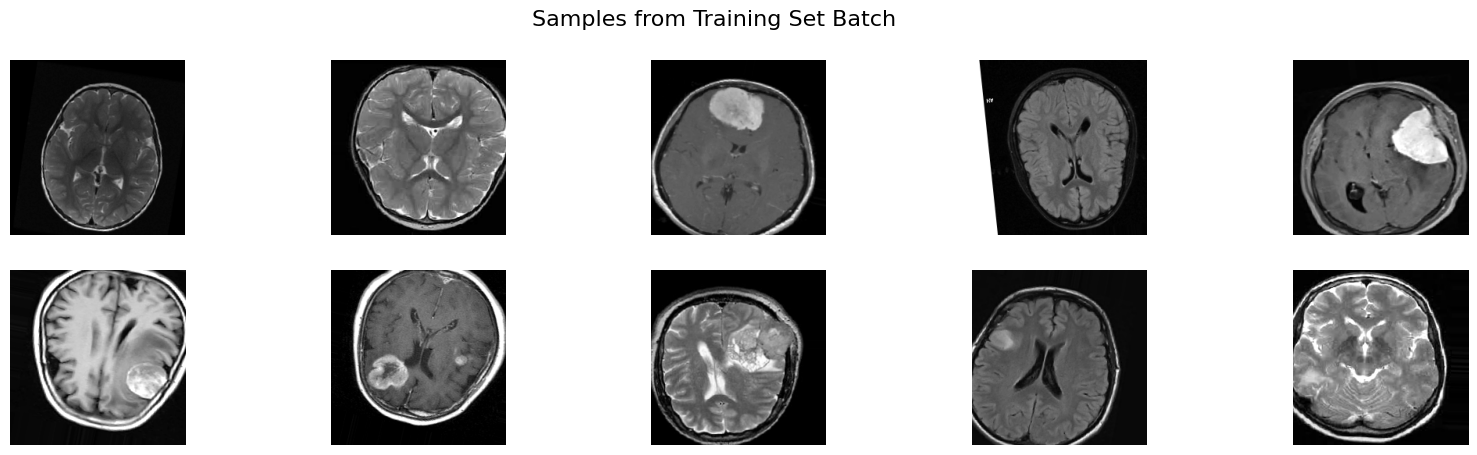

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_generator[0][0][:11]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

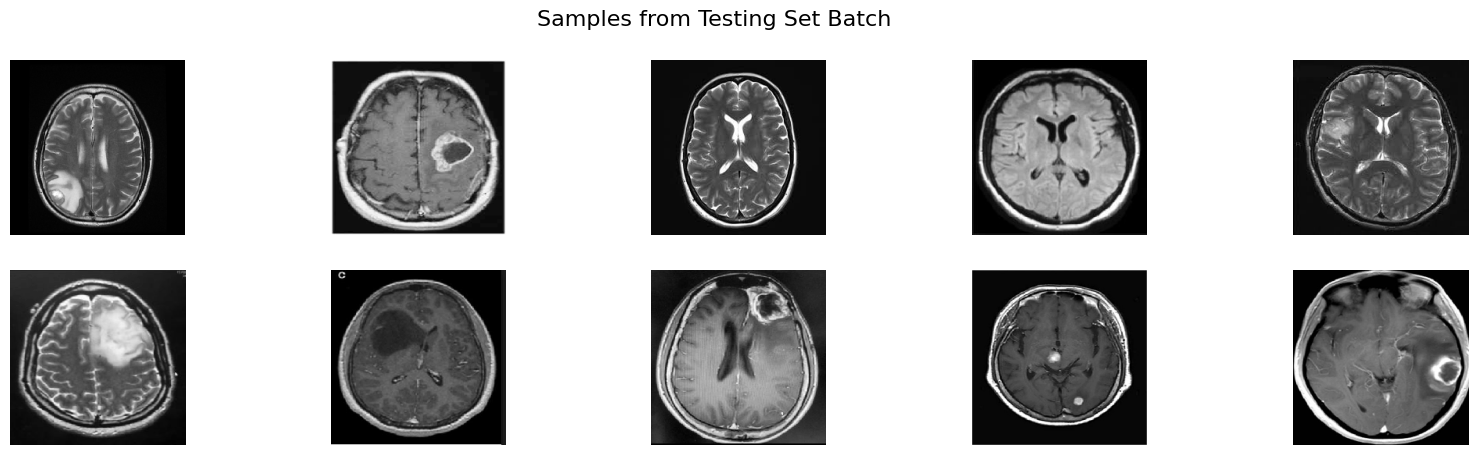

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_generator[0][0][:11]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

# 3. Machine Learning


###MLP

In [ ]:
mlp_model = keras.Sequential([
    keras.layers.Flatten(input_shape = (image_size, image_size, 1)),
    
    keras.layers.Dense(2048,activation="relu"), 
            
    keras.layers.Dropout(rate=0.2),    
    
    keras.layers.Dense(1024,activation="relu"),

    keras.layers.Dropout(rate=0.2),    

    keras.layers.Dense(512,activation="relu"),

    keras.layers.Dropout(rate=0.2),    

    keras.layers.Dense(256,activation="relu"),

    keras.layers.Dense(1,activation="sigmoid")
])

In [ ]:
from keras.backend import binary_crossentropy
#set learning rate 
learn_rate = 0.001 
adamOptimizer = keras.optimizers.Adam(learning_rate=learn_rate)
mlp_model.compile(optimizer=adamOptimizer,
                 loss=binary_crossentropy,
                 metrics=["accuracy"])

In [ ]:
history = mlp_model.fit(train_generator, epochs=50)


Epoch 1/50
5/5 [==============================] - 28s 5s/step - loss: 37.8939 - accuracy: 0.5177
Epoch 2/50
5/5 [==============================] - 1s 245ms/step - loss: 14.2229 - accuracy: 0.4894
Epoch 3/50
5/5 [==============================] - 1s 242ms/step - loss: 11.1599 - accuracy: 0.6028
Epoch 4/50
5/5 [==============================] - 2s 362ms/step - loss: 10.2865 - accuracy: 0.5390
Epoch 5/50
5/5 [==============================] - 2s 353ms/step - loss: 7.2958 - accuracy: 0.5248
Epoch 6/50
5/5 [==============================] - 1s 235ms/step - loss: 6.0424 - accuracy: 0.4894
Epoch 7/50
5/5 [==============================] - 1s 248ms/step - loss: 3.6498 - accuracy: 0.5106
Epoch 8/50
5/5 [==============================] - 1s 283ms/step - loss: 2.7405 - accuracy: 0.6241
Epoch 9/50
5/5 [==============================] - 1s 253ms/step - loss: 4.1441 - accuracy: 0.4468
Epoch 10/50
5/5 [==============================] - 1s 237ms/step - loss: 2.3051 - accuracy: 0.4823
Epoch 11/50
5/5 [

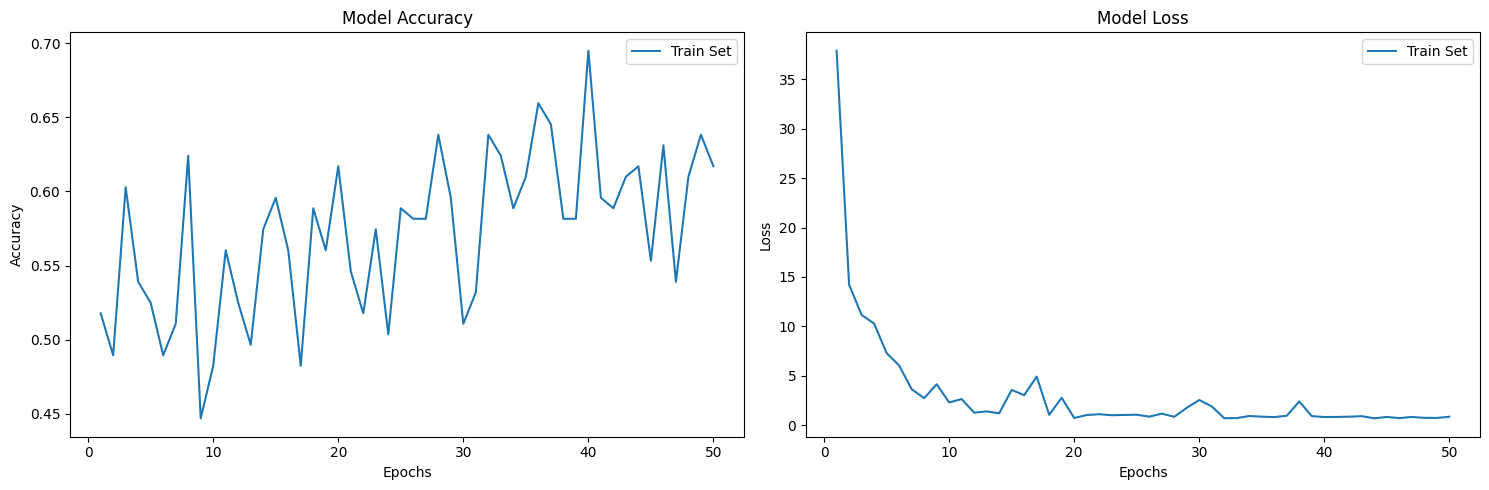

In [ ]:
# plot model performance
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
x_test, y_test = [], []

# Iterate over the test generator to extract the images and labels
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    x_test.append(images)
    y_test.append(labels)

# Concatenate the image and label arrays
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

# Verify the shapes of x_test and y_test
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (76, 224, 224, 1)
y_test shape: (76,)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

predictions = mlp_model.predict(x_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score = %.2f' % f1)

confusion_mtx = confusion_matrix(y_test, predictions)
print(confusion_mtx)

3/3 [==============================] - 0s 7ms/step
Test Accuracy = 0.59
F1 Score = 0.00
[[45  0]
 [31  0]]


In [ ]:
from keras.backend import binary_crossentropy
#set learning rate 
learn_rate = 0.001 
adamOptimizer = keras.optimizers.Adam(learning_rate=learn_rate)
mlp_model.compile(optimizer=adamOptimizer,
                 loss=binary_crossentropy,
                 metrics=[keras.metrics.Precision(),keras.metrics.Recall()])

In [ ]:
history = mlp_model.fit(train_generator, epochs=20)


Epoch 1/20
5/5 [==============================] - 3s 169ms/step - loss: 3.8171 - precision_2: 0.3934 - recall_2: 0.4444
Epoch 2/20
5/5 [==============================] - 1s 231ms/step - loss: 1.1602 - precision_2: 0.4348 - recall_2: 0.5556
Epoch 3/20
5/5 [==============================] - 1s 321ms/step - loss: 1.0146 - precision_2: 0.5263 - recall_2: 0.5556
Epoch 4/20
5/5 [==============================] - 2s 331ms/step - loss: 0.8503 - precision_2: 0.5676 - recall_2: 0.3889
Epoch 5/20
5/5 [==============================] - 2s 327ms/step - loss: 0.9924 - precision_2: 0.4717 - recall_2: 0.4630
Epoch 6/20
5/5 [==============================] - 1s 237ms/step - loss: 0.7500 - precision_2: 0.5345 - recall_2: 0.5741
Epoch 7/20
5/5 [==============================] - 1s 242ms/step - loss: 1.3263 - precision_2: 0.4400 - recall_2: 0.4074
Epoch 8/20
5/5 [==============================] - 1s 247ms/step - loss: 0.8805 - precision_2: 0.4630 - recall_2: 0.4630
Epoch 9/20
5/5 [========================

### CNN

In [ ]:
cnn_model = keras.models.Sequential([
  keras.layers.Conv2D(filters=64, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(224, 224, 1)), 
  keras.layers.Conv2D(32, 3, activation="relu"),
  keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  keras.layers.Conv2D(32, 3, activation="relu"),
  keras.layers.Conv2D(32, 3, activation="relu"), 
  keras.layers.MaxPool2D(2),
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation="relu"), 
  keras.layers.Dense(128, activation="relu"), 
  keras.layers.Dense(1, activation="sigmoid") 
])

In [ ]:
cnn_model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history = cnn_model.fit(train_generator, epochs=50)

Epoch 1/50
5/5 [==============================] - 14s 664ms/step - loss: 0.7270 - accuracy: 0.5887
Epoch 2/50
5/5 [==============================] - 1s 265ms/step - loss: 0.7676 - accuracy: 0.6170
Epoch 3/50
5/5 [==============================] - 1s 256ms/step - loss: 0.6659 - accuracy: 0.5887
Epoch 4/50
5/5 [==============================] - 1s 249ms/step - loss: 0.5949 - accuracy: 0.7021
Epoch 5/50
5/5 [==============================] - 1s 270ms/step - loss: 0.6549 - accuracy: 0.5816
Epoch 6/50
5/5 [==============================] - 2s 302ms/step - loss: 0.5984 - accuracy: 0.6879
Epoch 7/50
5/5 [==============================] - 2s 343ms/step - loss: 0.5706 - accuracy: 0.7376
Epoch 8/50
5/5 [==============================] - 1s 258ms/step - loss: 0.5324 - accuracy: 0.7305
Epoch 9/50
5/5 [==============================] - 1s 308ms/step - loss: 0.5424 - accuracy: 0.7305
Epoch 10/50
5/5 [==============================] - 1s 259ms/step - loss: 0.5143 - accuracy: 0.7730
Epoch 11/50
5/5 [=

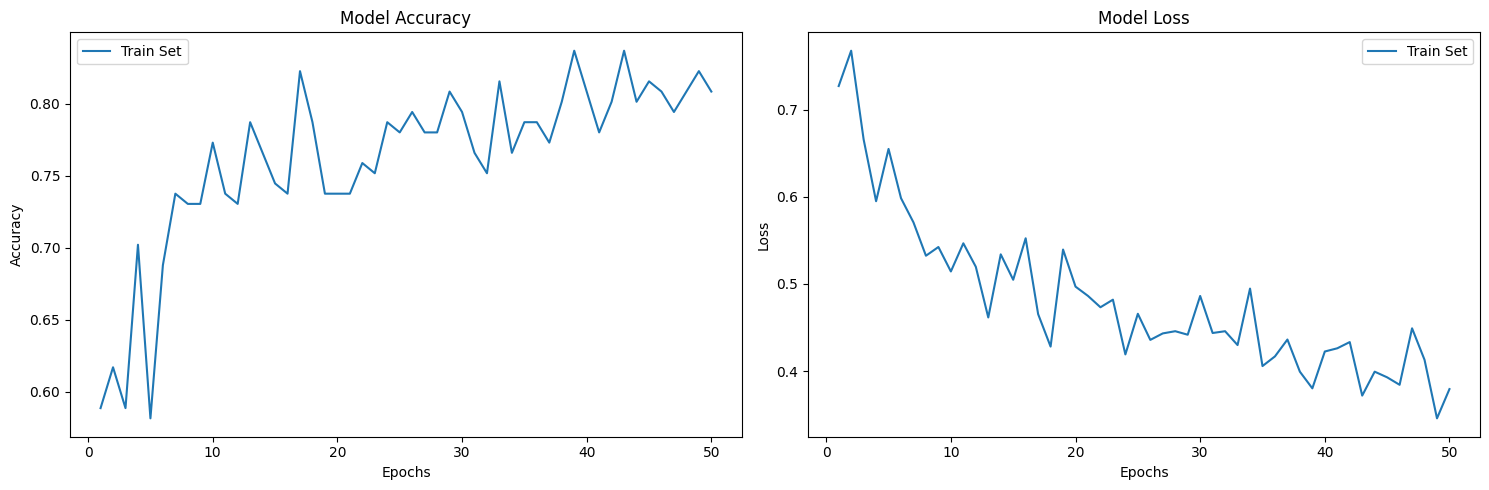

In [ ]:
# plot model performance
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

predictions = cnn_model.predict(x_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score = %.2f' % f1)

confusion_mtx = confusion_matrix(y_test, predictions)
print(confusion_mtx)

3/3 [==============================] - 1s 358ms/step
Test Accuracy = 0.75
F1 Score = 0.72
[[32 13]
 [ 6 25]]


### VGG16

In [ ]:
base_model = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape = (224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.backend import binary_crossentropy

NUM_CLASSES = 1

model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50,activation="relu"))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(20,activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

adamOptimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss=binary_crossentropy,
    optimizer=adamOptimizer,
    metrics=['accuracy']
)
# or metrics=[keras.metrics.Precision()]

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 50)                1254450   
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 15,969,189
Trainable params: 1,254,501
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
EPOCHS = 50

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS
)

<ipython-input-128-c27009d5d36f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
5/5 [==============================] - 3s 321ms/step - loss: 8.0269 - accuracy: 0.5887
Epoch 2/50
5/5 [==============================] - 2s 495ms/step - loss: 2.6740 - accuracy: 0.7234
Epoch 3/50
5/5 [==============================] - 2s 405ms/step - loss: 2.1112 - accuracy: 0.7021
Epoch 4/50
5/5 [==============================] - 2s 407ms/step - loss: 0.5558 - accuracy: 0.6099
Epoch 5/50
5/5 [==============================] - 2s 412ms/step - loss: 0.5909 - accuracy: 0.5674
Epoch 6/50
5/5 [==============================] - 2s 412ms/step - loss: 0.5564 - accuracy: 0.5887
Epoch 7/50
5/5 [==============================] - 2s 494ms/step - loss: 0.6404 - accuracy: 0.7021
Epoch 8/50
5/5 [==============================] - 2s 498ms/step - loss: 0.5050 - accuracy: 0.7021
Epoch 9/50
5/5 [==============================] - 2s 424ms/step - loss: 0.4833 - accuracy: 0.7376
Epoch 10/50
5/5 [==============================] - 2s 418ms/step - loss: 0.4930 - accuracy: 0.7163
Epoch 11/50
5/5 [==

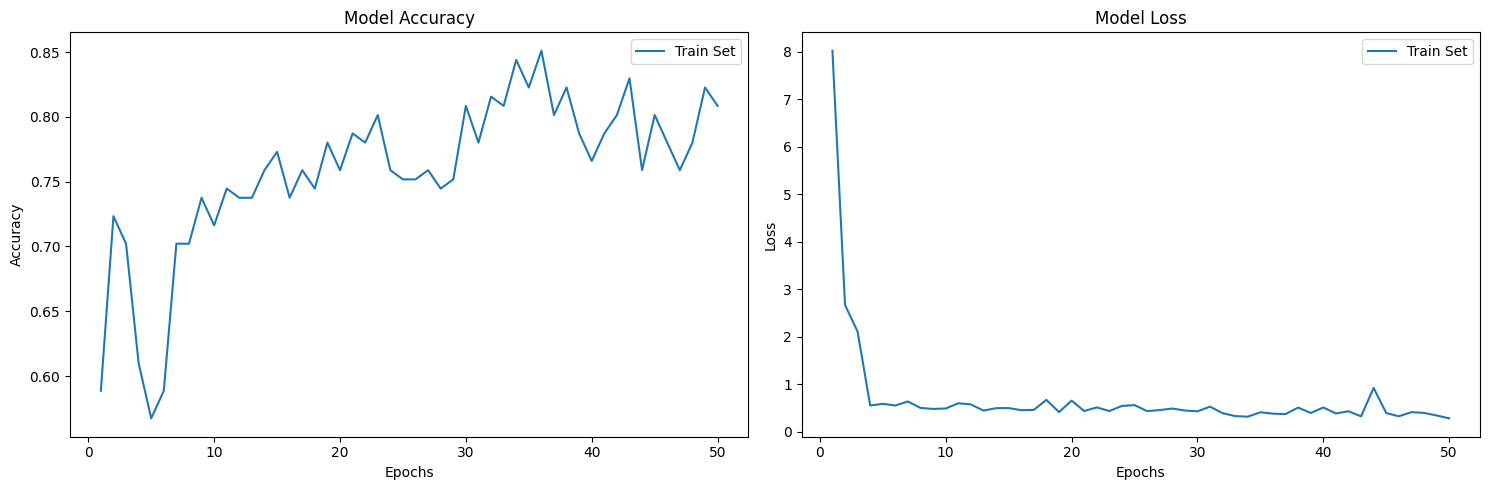

In [ ]:
# plot model performance
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
x_test, y_test = [], []

# Iterate over the test generator to extract the images and labels
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    x_test.append(images)
    y_test.append(labels)

# Concatenate the image and label arrays
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

# Verify the shapes of x_test and y_test
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (76, 224, 224, 3)
y_test shape: (76,)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

predictions = model.predict(x_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score = %.2f' % f1)

confusion_mtx = confusion_matrix(y_test, predictions)
print(confusion_mtx)

3/3 [==============================] - 0s 23ms/step
Test Accuracy = 0.86
F1 Score = 0.80
[[43  2]
 [ 9 22]]
